In [132]:
import numpy as np          
import argparse
import pandas as pd
#from termcolor import colored
import sys
sys.path.insert(1, './src/')
from scotv1 import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
import igraph as ig
import re
import warnings

from scipy.stats import mannwhitneyu
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.miscmodels.ordinal_model import OrderedModel
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ranksums
from scipy.stats import mannwhitneyu
from scipy import stats
import seaborn as sns

# 1 Read in data

In [133]:
# Blood ROSMAP
ROSMAPFrame = pd.read_csv("../../../Data/ROSMAP_blood_gene_expression_monocyte_ACTL_04172023.csv",header=0, index_col=0)
ROSMAPSampleID = list(ROSMAPFrame.columns.values)
ROSMAPGeneID = list(ROSMAPFrame.index.values)

# Blood ANMerge
ANMergeFrame = pd.read_csv("../../../Data/ADNI_blood_gene_expression_gene_aligned_04172023.csv",header=0, index_col=0)
ANMergeGeneID = list(ANMergeFrame.index.values)
ANMergeSampleID = list(ANMergeFrame.columns.values)

In [134]:
ROSMAPFrame

,Sample_003,Sample_004,Sample_014,Sample_021,Sample_031,Sample_037,Sample_040,Sample_050,Sample_057,Sample_058,...,Sample_563,Sample_572,Sample_573,Sample_578,Sample_580,Sample_581,Sample_582,Sample_588,Sample_590,Sample_608
A1BG,4.0,1,2,14.0,1.0,4.0,7,5.0,2,8,...,5.0,10.0,18,8,2,0,0.5,0,12.0,1.0
A2M,5.0,0,0,18.0,4.0,22.0,34,21.0,6,8,...,7.0,9.0,13,14,6,1,0.0,0,11.0,26.0
A4GALT,0.0,0,1,11.0,0.0,0.0,0,3.0,0,8,...,1.0,5.0,0,0,0,0,1.0,0,0.0,0.0
AAAS,121.0,92,1,103.0,156.0,138.0,140,76.0,36,65,...,32.0,107.0,94,68,32,14,36.5,0,105.0,93.0
AAK1,518.0,745,4542,435.0,270.0,448.0,433,406.0,260,148,...,130.0,316.0,302,446,396,114,4121.0,0,232.0,300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,148.0,83,59,78.0,61.0,72.0,105,66.0,40,46,...,27.0,70.0,72,78,83,22,11.5,0,79.0,58.0
ZYG11B,162.0,221,3137,167.0,83.0,212.0,146,119.0,26,139,...,66.0,78.0,143,142,137,31,1689.5,0,90.0,88.0
ZYX,2084.0,1395,20628,1261.0,1180.0,1434.0,494,1194.0,361,1939,...,815.0,1026.0,1834,1545,821,452,7690.5,9,1582.0,648.0
ZZEF1,784.0,961,957,612.0,321.0,585.0,392,696.0,322,205,...,317.0,409.0,455,520,483,159,875.0,0,530.0,316.0


In [135]:
# log transform ROSMAP
ROSMAPFrame = np.log(ROSMAPFrame+1)

# gene overlap between ROSMAP and ANMerge
OverlapGene = list(set(ROSMAPGeneID) & set(ANMergeGeneID))
print("Number of overlapped gene is", len(OverlapGene))

Number of overlapped gene is 7704


## 1.1 Aligned dataframe to make their gene aligned

In [136]:
#ROSMAPFrame = ROSMAPFrame.loc[OverlapGene,:]
#ANMergeFrame = ANMergeFrame.loc[OverlapGene,:]

In [137]:
ROSMAPFrame

,Sample_003,Sample_004,Sample_014,Sample_021,Sample_031,Sample_037,Sample_040,Sample_050,Sample_057,Sample_058,...,Sample_563,Sample_572,Sample_573,Sample_578,Sample_580,Sample_581,Sample_582,Sample_588,Sample_590,Sample_608
A1BG,1.609438,0.693147,1.098612,2.708050,0.693147,1.609438,2.079442,1.791759,1.098612,2.197225,...,1.791759,2.397895,2.944439,2.197225,1.098612,0.000000,0.405465,0.000000,2.564949,0.693147
A2M,1.791759,0.000000,0.000000,2.944439,1.609438,3.135494,3.555348,3.091042,1.945910,2.197225,...,2.079442,2.302585,2.639057,2.708050,1.945910,0.693147,0.000000,0.000000,2.484907,3.295837
A4GALT,0.000000,0.000000,0.693147,2.484907,0.000000,0.000000,0.000000,1.386294,0.000000,2.197225,...,0.693147,1.791759,0.000000,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000
AAAS,4.804021,4.532599,0.693147,4.644391,5.056246,4.934474,4.948760,4.343805,3.610918,4.189655,...,3.496508,4.682131,4.553877,4.234107,3.496508,2.708050,3.624341,0.000000,4.663439,4.543295
AAK1,6.251904,6.614726,8.421343,6.077642,5.602119,6.107023,6.073045,6.008813,5.564520,5.003946,...,4.875197,5.758902,5.713733,6.102559,5.983936,4.744932,8.324094,0.000000,5.451038,5.707110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,5.003946,4.430817,4.094345,4.369448,4.127134,4.290459,4.663439,4.204693,3.713572,3.850148,...,3.332205,4.262680,4.290459,4.369448,4.430817,3.135494,2.525729,0.000000,4.382027,4.077537
ZYG11B,5.093750,5.402677,8.051341,5.123964,4.430817,5.361292,4.990433,4.787492,3.295837,4.941642,...,4.204693,4.369448,4.969813,4.962845,4.927254,3.465736,7.432780,0.000000,4.510860,4.488636
ZYX,7.642524,7.241366,9.934453,7.140453,7.074117,7.268920,6.204558,7.085901,5.891644,7.570443,...,6.704414,6.934397,7.514800,7.343426,6.711740,6.115892,8.947871,2.302585,7.367077,6.475433
ZZEF1,6.665684,6.869014,6.864848,6.418365,5.774552,6.373320,5.973810,6.546785,5.777652,5.327876,...,5.762051,6.016157,6.122493,6.255750,6.182085,5.075174,6.775366,0.000000,6.274762,5.758902


In [138]:
ANMergeFrame

,116_S_1249,037_S_4410,006_S_4153,116_S_1232,099_S_4205,007_S_4467,128_S_0205,003_S_2374,036_S_4491,098_S_4059,...,082_S_4339,022_S_2379,014_S_4668,130_S_0289,141_S_4456,009_S_2381,053_S_4557,073_S_4300,041_S_4014,007_S_0101
A1BG,3.651000,3.183000,3.278000,3.371000,3.358000,3.504000,3.194000,3.002000,3.855000,3.59400,...,3.655000,3.345000,3.330000,3.368000,3.665000,3.302000,3.403000,3.53000,3.532000,3.298000
A2M,3.039000,3.543000,3.528000,3.835000,3.392000,3.081000,3.146000,3.281000,3.974000,3.51100,...,3.725000,3.441000,3.497000,3.128000,3.285000,3.524000,3.515000,3.65100,3.609000,3.804000
A4GALT,2.056500,2.349000,2.526000,2.472000,2.296500,2.353500,2.548000,2.396500,3.026500,2.57200,...,2.582500,2.585500,2.598000,2.374000,2.627000,2.838000,2.771500,2.32800,2.823000,2.774500
AAAS,7.043000,6.773000,6.910000,7.209000,6.920000,7.053000,7.079000,6.618000,7.382000,6.82000,...,7.024000,7.028000,6.950000,6.878000,7.233000,6.805000,7.265000,7.37500,7.257000,6.970000
AAK1,4.282167,4.661833,4.661500,4.608833,4.770167,4.618000,5.224333,4.104500,4.282333,4.42950,...,4.667833,4.728333,4.845333,4.156500,4.826333,4.581667,4.654167,4.50750,4.462667,4.452500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,4.739500,4.702333,4.545333,4.562500,4.890667,4.597833,4.599333,4.643333,4.559833,4.57150,...,4.665833,4.395333,4.435333,4.723667,4.468000,4.472167,4.609833,4.73350,4.091000,4.362333
ZYG11B,5.317500,5.388000,5.628000,5.463000,5.647500,5.573250,5.561250,5.611250,5.293750,5.40025,...,5.320250,5.524250,5.411250,5.362500,5.259750,5.442750,5.140000,5.38775,5.057250,4.992000
ZYX,9.219000,8.378500,9.108500,9.321000,9.030000,8.963500,8.534500,9.034000,10.088000,9.35650,...,9.879500,9.403000,9.310500,9.196500,9.506000,9.290000,9.809000,9.52150,9.581000,9.922500
ZZEF1,7.301000,6.758000,7.336500,7.168500,7.202500,7.047500,6.917500,6.950000,7.680000,6.82400,...,7.536000,7.097500,6.766000,7.177000,6.975000,6.703500,7.281000,6.98250,6.686500,7.264500


## 1.2 Read in labels

In [139]:
# read in label
ROSMAP_Info = pd.read_csv("../../../Data/ROSMAP_blood_clinical_monocyte_ACTL_04172023.csv",header=0, index_col=0)

# read in label
ANMerge_Info = pd.read_csv("../../../Data/ADNI_blood_clinical_04172023.csv",header=0, index_col=0)
    
# MMSE Info
Add_Info = pd.read_csv("../../../Data/ADNI_Clinical_plus_PTau_MMSE_AV45.csv",header=0, index_col=0)


In [140]:
ROSMAP_Info

,individualID,projid,msex,race,apoe_genotype,age_at_visit_max,age_death,cts_mmse30_lv,pmi,braaksc,ceradsc,cogdx,dcfdx_lv,Group1,Group2,specimenID
1,R1528689,402800,0,1,34.0,79.701574264202605,80.65708418891171,13.0,5.500000,5,1,4,4,Typical AD,Typical.AD,Sample_003
2,R3978789,482428,0,1,23.0,82.321697467488022,83.690622861054067,30.0,3.933333,4,4,1,1,Asym AD,Asym.AD,Sample_004
3,R5422277,3052480,0,1,23.0,90+,90+,15.0,10.583333,4,2,2,2,Asym AD,Asym.AD,Sample_014
4,R1408411,4127190,0,1,23.0,87.750855578370974,88.637919233401774,29.0,18.166667,2,4,1,1,Control,Control,Sample_021
5,R9033345,6107196,1,1,33.0,90+,90+,22.0,4.166667,5,1,4,4,Typical AD,Typical.AD,Sample_031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,R4937504,92393245,0,1,23.0,90+,90+,26.0,8.283333,5,1,1,1,Asym AD,Asym.AD,Sample_581
154,R6119857,92427316,1,1,33.0,88.662559890485966,89.226557152635181,24.0,43.883333,4,1,1,1,Asym AD,Asym.AD,Sample_582
155,R8186418,93787649,1,1,33.0,86.132785763175903,86.35455167693361,27.0,4.250000,1,2,5,5,Low-NFT AD,LowNFT.AD,Sample_588
156,R2157677,94144536,0,1,33.0,90+,90+,24.0,8.216667,5,1,2,2,Asym AD,Asym.AD,Sample_590


In [141]:
import collections

ROSMAP_SID = list(ROSMAP_Info.loc[:,'specimenID'])
ROSMAP_Class = list(ROSMAP_Info.loc[:,'Group2'])
Mapping = {'Control': 0, 'Typical.AD': 1, 'Asym.AD': 2, 'LowNFT.AD': 3}
DigitClass = list()
for i in range(len(ROSMAP_SID)):
    tmp = Mapping[ROSMAP_Class[i]]
    DigitClass.append(tmp)


#ANMerge_SID = list(ANMerge_Info.index.values)
#ANMerge_Class = list(ANMerge_Info.loc[:,'Diagnosis'])
ANMerge_SID = list(ANMerge_Info.loc[:,'PTID'])
ANMerge_Class = list(ANMerge_Info.loc[:,'DX'])
Mapping = {'CN': 0, 'Dementia': 1, 'MCI': 2}
Mapping_SID_Class = {}
for i in range(len(ANMerge_SID)):
    Mapping_SID_Class[ANMerge_SID[i]] = ANMerge_Class[i]

# used in section 3.1
y_true = np.zeros(len(ANMergeSampleID))
for i in range(len(ANMergeSampleID)):
    y_true[i] = Mapping[Mapping_SID_Class[ANMergeSampleID[i]]]



In [142]:
y_true

array([0., 0., 1., 0., 2., 2., 0., 2., 0., 2., 2., 2., 2., 2., 2., 0., 0.,
       2., 2., 0., 0., 2., 2., 2., 2., 2., 1., 1., 2., 2., 2., 1., 2., 2.,
       1., 2., 2., 1., 2., 2., 0., 0., 0., 2., 0., 0., 2., 0., 1., 0., 2.,
       2., 2., 2., 2., 2., 0., 0., 0., 2., 0., 0., 2., 2., 0., 2., 2., 0.,
       1., 0., 0., 2., 2., 0., 0., 0., 2., 2., 1., 0., 2., 1., 0., 0., 0.,
       2., 2., 2., 0., 0., 2., 0., 2., 0., 1., 2., 2., 2., 2., 0., 1., 2.,
       2., 2., 2., 1., 1., 2., 0., 1., 2., 2., 0., 0., 0., 2., 2., 2., 0.,
       2., 2., 2., 1., 2., 0., 2., 2., 2., 0., 0., 0., 2., 1., 0., 2., 2.,
       0., 2., 2., 2., 1., 0., 2., 2., 0., 1., 0., 2., 2., 1., 2., 2., 0.,
       0., 2., 1., 0., 2., 1., 2., 0., 2., 2., 2., 1., 2., 0., 1., 2., 2.,
       2., 1., 0., 0., 1., 0., 2., 2., 2., 0., 2., 0., 2., 2., 2., 2., 0.,
       2., 2., 0., 0., 2., 2., 0., 0., 2., 2., 0., 2., 0., 1., 0., 2., 2.,
       0., 0., 0., 0., 2., 0., 0., 1., 1., 2., 2., 1., 2., 0., 0., 2., 0.,
       0., 0., 2., 1., 2.

In [143]:
#ANMerge_Class

# 2 Run SCOT

In [144]:
ROSMAP = ROSMAPFrame.values.T
ANMerge = ANMergeFrame.values.T

IndR = np.tile(np.arange(157), 5)
ROSMAP = ROSMAP[IndR[0:len(ANMergeSampleID)],:]

In [145]:
ROSMAP

array([[1.60943791, 1.79175947, 0.        , ..., 7.64252413, 6.66568372,
        4.48863637],
       [0.69314718, 0.        , 0.        , ..., 7.24136628, 6.86901445,
        3.95124372],
       [1.09861229, 0.        , 0.69314718, ..., 9.93445313, 6.86484778,
        1.09861229],
       ...,
       [3.09104245, 2.7080502 , 0.        , ..., 7.68524361, 6.02102335,
        4.4543473 ],
       [1.09861229, 2.19722458, 0.        , ..., 6.35088572, 5.78689738,
        4.51085951],
       [1.09861229, 2.99573227, 0.69314718, ..., 7.81722279, 6.35957387,
        4.07753744]])

In [146]:
ANMerge

array([[3.651 , 3.039 , 2.0565, ..., 9.219 , 7.301 , 5.749 ],
       [3.183 , 3.543 , 2.349 , ..., 8.3785, 6.758 , 6.0935],
       [3.278 , 3.528 , 2.526 , ..., 9.1085, 7.3365, 5.2615],
       ...,
       [3.53  , 3.651 , 2.328 , ..., 9.5215, 6.9825, 5.0785],
       [3.532 , 3.609 , 2.823 , ..., 9.581 , 6.6865, 3.866 ],
       [3.298 , 3.804 , 2.7745, ..., 9.9225, 7.2645, 4.608 ]])

In [147]:
scot=SCOT(ROSMAP, ANMerge)

In [148]:
ROSMAP_new, ANMerge_new = scot.align(k=30, e=1e-3,  normalize=True, norm="l1")

It.  |Err         
-------------------
    0|2.231315e-03|


/Users/yijwang-admin/anaconda3/lib/python3.10/site-packages/ot/bregman.py:535: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


   10|2.202251e-03|
   20|1.316614e-03|
   30|2.810345e-04|
   40|5.326895e-05|
   50|1.365304e-05|
   60|5.133815e-06|
   70|2.601553e-06|
   80|1.469123e-06|
   90|8.529826e-07|
  100|4.995812e-07|
  110|2.937587e-07|
  120|1.731154e-07|
  130|1.021530e-07|
  140|6.032657e-08|
  150|3.564276e-08|
  160|2.106476e-08|
  170|1.245129e-08|
  180|7.360637e-09|
  190|4.351532e-09|
It.  |Err         
-------------------
  200|2.572670e-09|
  210|1.521021e-09|
  220|8.992726e-10|


In [149]:
ANMerge_new

array([[7.88147695e-05, 6.56034194e-05, 4.43940217e-05, ...,
        1.99012150e-04, 1.57607952e-04, 1.24104659e-04],
       [6.84016910e-05, 7.61379803e-05, 5.04792875e-05, ...,
        1.80051388e-04, 1.45227341e-04, 1.30947441e-04],
       [7.14449148e-05, 7.68937338e-05, 5.50548672e-05, ...,
        1.98522272e-04, 1.59901043e-04, 1.14675845e-04],
       ...,
       [7.65374660e-05, 7.91609882e-05, 5.04756999e-05, ...,
        2.06445179e-04, 1.51394577e-04, 1.10112046e-04],
       [7.72940891e-05, 7.89791527e-05, 6.17783730e-05, ...,
        2.09670064e-04, 1.46326989e-04, 8.46033262e-05],
       [7.19405215e-05, 8.29780909e-05, 6.05212180e-05, ...,
        2.16443246e-04, 1.58463286e-04, 1.00516047e-04]])

# 3 UMAP Plot

In [150]:
import umap
import sklearn.datasets
import umap.plot

In [151]:
# Umap need a matrix obs by features
Embed_Stack = np.vstack((ROSMAP_new,ANMerge_new))

# label
N_K1 = np.shape(ROSMAP_new)[0]
Label = np.zeros(np.shape(Embed_Stack)[0])
Label[N_K1:] = 1

mapper = umap.UMAP().fit(Embed_Stack)

<Axes: >

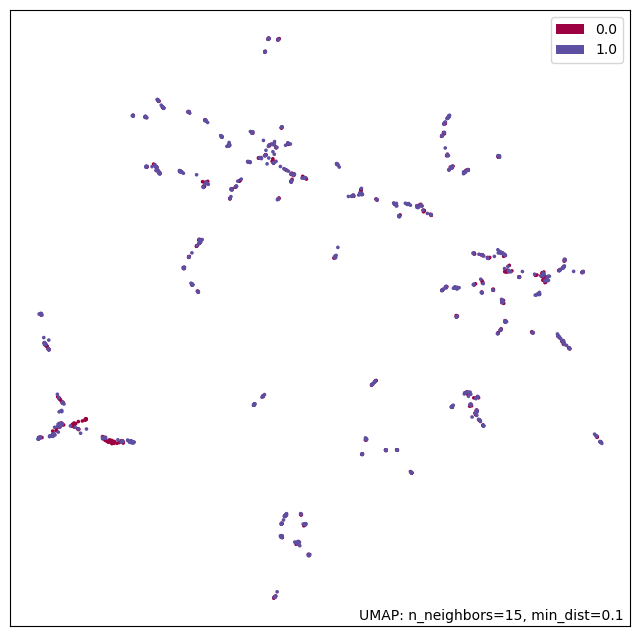

In [152]:
umap.plot.points(mapper, labels=Label)

## 3.1 KNN to transfer labels

In [153]:
#PCA
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
Xy_pca=pca.fit_transform(np.concatenate((ROSMAP_new, ANMerge_new), axis=0))
X_pca=Xy_pca[0: 744,]
y_pca=Xy_pca[744:,]


In [154]:
X_pca

array([[ 2.19927867e-04, -1.46552408e-04],
       [ 1.65019605e-04,  1.56834745e-04],
       [-5.18792703e-04, -9.38263814e-06],
       ...,
       [ 1.59334867e-04, -2.53709719e-04],
       [ 5.12697405e-05,  9.92023891e-05],
       [-1.81978902e-05, -1.14830416e-04]])

In [155]:
from sklearn.neighbors import KNeighborsClassifier

ROSMAP_new_ = X_pca[0:157,:]#ROSMAP_new[0:157,:]#
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(ROSMAP_new_,DigitClass)

KNeighborsClassifier(n_neighbors=1)

In [156]:
ROSMAP_new_

array([[ 2.19927867e-04, -1.46552408e-04],
       [ 1.65019605e-04,  1.56834745e-04],
       [-5.18792703e-04, -9.38263814e-06],
       [ 5.74737197e-04,  3.57345157e-05],
       [-1.47915415e-04,  1.34050382e-04],
       [ 1.76608819e-04,  1.48543467e-04],
       [ 8.53596290e-04,  1.17471463e-06],
       [-1.48840824e-04, -1.92052250e-05],
       [ 2.82311534e-05,  1.04549553e-04],
       [ 4.22610476e-05, -3.80827382e-04],
       [-1.61465691e-04,  2.58939126e-04],
       [-5.14493084e-04, -4.83583823e-05],
       [ 1.55091065e-04,  1.40133953e-05],
       [ 6.61056371e-05,  1.93067040e-04],
       [-5.15669562e-04, -7.42031172e-05],
       [ 1.26812238e-04,  1.25163360e-04],
       [-5.43712597e-05, -5.68189903e-05],
       [ 3.90720187e-05,  6.64666531e-06],
       [ 1.82312103e-04, -1.04749016e-04],
       [-1.97178747e-04, -1.16648500e-04],
       [ 1.82374539e-04, -1.95729388e-04],
       [-2.06776850e-04,  1.74814670e-04],
       [ 3.83461609e-04, -4.84402989e-05],
       [-6.

In [157]:
y_pred = np.zeros(len(ANMergeSampleID))
y_pred = -1+y_pred

for i in range(len(ANMergeSampleID)):
    y_pred[i] = neigh.predict([y_pca[i,:]])#neigh.predict([ANMerge_new[i,:]])#

In [158]:
y_pred

array([1., 2., 1., 2., 2., 2., 1., 1., 1., 2., 2., 2., 0., 2., 2., 1., 2.,
       2., 2., 2., 2., 2., 1., 2., 3., 2., 1., 2., 1., 2., 2., 2., 2., 0.,
       0., 2., 2., 1., 2., 2., 0., 0., 1., 1., 1., 2., 3., 1., 0., 2., 2.,
       2., 1., 2., 1., 2., 1., 2., 0., 0., 2., 2., 2., 1., 2., 1., 3., 2.,
       1., 2., 2., 0., 1., 2., 2., 2., 0., 2., 2., 2., 1., 2., 1., 2., 2.,
       1., 1., 1., 2., 2., 1., 2., 1., 1., 3., 2., 2., 1., 2., 2., 2., 2.,
       2., 2., 0., 2., 3., 2., 2., 2., 2., 2., 1., 2., 1., 2., 2., 2., 2.,
       1., 1., 2., 2., 2., 1., 3., 2., 3., 1., 0., 1., 2., 1., 1., 1., 2.,
       2., 1., 2., 2., 2., 1., 1., 2., 0., 2., 1., 1., 2., 2., 1., 2., 1.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 0., 2., 1.,
       1., 1., 2., 2., 2., 1., 0., 2., 2., 2., 2., 0., 2., 1., 2., 3., 2.,
       2., 2., 1., 0., 0., 2., 2., 0., 3., 0., 2., 1., 1., 1., 2., 2., 1.,
       1., 2., 3., 2., 2., 1., 3., 2., 2., 2., 3., 0., 2., 2., 2., 1., 2.,
       2., 1., 1., 2., 2.

## 3.2 Evaulation

In [159]:
y_pred

array([1., 2., 1., 2., 2., 2., 1., 1., 1., 2., 2., 2., 0., 2., 2., 1., 2.,
       2., 2., 2., 2., 2., 1., 2., 3., 2., 1., 2., 1., 2., 2., 2., 2., 0.,
       0., 2., 2., 1., 2., 2., 0., 0., 1., 1., 1., 2., 3., 1., 0., 2., 2.,
       2., 1., 2., 1., 2., 1., 2., 0., 0., 2., 2., 2., 1., 2., 1., 3., 2.,
       1., 2., 2., 0., 1., 2., 2., 2., 0., 2., 2., 2., 1., 2., 1., 2., 2.,
       1., 1., 1., 2., 2., 1., 2., 1., 1., 3., 2., 2., 1., 2., 2., 2., 2.,
       2., 2., 0., 2., 3., 2., 2., 2., 2., 2., 1., 2., 1., 2., 2., 2., 2.,
       1., 1., 2., 2., 2., 1., 3., 2., 3., 1., 0., 1., 2., 1., 1., 1., 2.,
       2., 1., 2., 2., 2., 1., 1., 2., 0., 2., 1., 1., 2., 2., 1., 2., 1.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 0., 2., 1.,
       1., 1., 2., 2., 2., 1., 0., 2., 2., 2., 2., 0., 2., 1., 2., 3., 2.,
       2., 2., 1., 0., 0., 2., 2., 0., 3., 0., 2., 1., 1., 1., 2., 2., 1.,
       1., 2., 3., 2., 2., 1., 3., 2., 2., 2., 3., 0., 2., 2., 2., 1., 2.,
       2., 1., 1., 2., 2.

In [160]:
y_true

array([0., 0., 1., 0., 2., 2., 0., 2., 0., 2., 2., 2., 2., 2., 2., 0., 0.,
       2., 2., 0., 0., 2., 2., 2., 2., 2., 1., 1., 2., 2., 2., 1., 2., 2.,
       1., 2., 2., 1., 2., 2., 0., 0., 0., 2., 0., 0., 2., 0., 1., 0., 2.,
       2., 2., 2., 2., 2., 0., 0., 0., 2., 0., 0., 2., 2., 0., 2., 2., 0.,
       1., 0., 0., 2., 2., 0., 0., 0., 2., 2., 1., 0., 2., 1., 0., 0., 0.,
       2., 2., 2., 0., 0., 2., 0., 2., 0., 1., 2., 2., 2., 2., 0., 1., 2.,
       2., 2., 2., 1., 1., 2., 0., 1., 2., 2., 0., 0., 0., 2., 2., 2., 0.,
       2., 2., 2., 1., 2., 0., 2., 2., 2., 0., 0., 0., 2., 1., 0., 2., 2.,
       0., 2., 2., 2., 1., 0., 2., 2., 0., 1., 0., 2., 2., 1., 2., 2., 0.,
       0., 2., 1., 0., 2., 1., 2., 0., 2., 2., 2., 1., 2., 0., 1., 2., 2.,
       2., 1., 0., 0., 1., 0., 2., 2., 2., 0., 2., 0., 2., 2., 2., 2., 0.,
       2., 2., 0., 0., 2., 2., 0., 0., 2., 2., 0., 2., 0., 1., 0., 2., 2.,
       0., 0., 0., 0., 2., 0., 0., 1., 1., 2., 2., 1., 2., 0., 0., 2., 0.,
       0., 0., 2., 1., 2.

In [161]:
#Mapping = {'Control': 0, 'Typical.AD': 1, 'Asym.AD': 2, 'LowNFT.AD': 3}
#Mapping = {'CTL': 0, 'AD': 1, 'MCI': 2}


pred_ind_cn = np.where(y_pred==0)[0]
true_ind_cn = np.where(y_true==0)[0]
overlap = list(set(pred_ind_cn) & set(true_ind_cn))

pred_ind_aad = np.where(y_pred==2)[0]
true_ind_aad = np.where(y_true==2)[0]
overlap = list(set(pred_ind_aad) & set(true_ind_aad))

pred_ind_tad = np.where(y_pred==1)[0]
true_ind_tad = np.where(y_true==1)[0]
true_ind_tad_aad = list(true_ind_aad) + list(true_ind_tad)
overlap = list(set(pred_ind_tad) & set(true_ind_tad_aad))
print("precision of TAD is ", len(overlap)/len(pred_ind_tad))

pred_ind_aad_cn = list(pred_ind_aad) #+ list(pred_ind_cn)
true_ind_aad_cn = list(true_ind_cn) + list(true_ind_aad)
overlap = list(set(pred_ind_aad_cn) & set(true_ind_aad_cn))
print("precision of AAD  is ", len(overlap)/len(pred_ind_aad_cn))

pred_ind_aad_cn = list(pred_ind_cn) #list(pred_ind_aad) + 
true_ind_aad_cn = list(true_ind_cn) + list(true_ind_aad)
overlap = list(set(pred_ind_aad_cn) & set(true_ind_aad_cn))
if len(pred_ind_aad_cn) == 0:
    print("precision of CN  is 0")
else:
    print("precision of CN  is ", len(overlap)/len(pred_ind_aad_cn))

pred_ind_lt = np.where(y_pred==3)[0]
true_ind_lt = np.where(y_true==1)[0]
true_ind_lt_aad = list(true_ind_aad) + list(true_ind_lt)
overlap = list(set(pred_ind_lt) & set(true_ind_lt_aad))
if len(pred_ind_lt) == 0:
    print("precision of LowTau is 0")
else:
    print("precision of LowTau is ", len(overlap)/len(pred_ind_lt))

precision of TAD is  0.7
precision of AAD  is  0.8349514563106796
precision of CN  is  0.8875
precision of LowTau is  0.75


In [162]:
ReverseMapping = {0:'Control', 1:'Typical AD', 2: 'Asym AD', 3: 'Low-NFT AD'}
ADNI_SID = ANMergeFrame.columns.values
print(len(ADNI_SID))

Mapping_SID_Label = {}
for i in range(len(ADNI_SID)):
    Mapping_SID_Label[ADNI_SID[i]] = ReverseMapping[y_pred[i]]


744


In [163]:
SID = list(Add_Info.index)
LabelList = list()
for st in SID:
    LabelList.append(Mapping_SID_Label[st])
print(LabelList)

['Typical AD', 'Asym AD', 'Typical AD', 'Asym AD', 'Asym AD', 'Asym AD', 'Typical AD', 'Typical AD', 'Typical AD', 'Asym AD', 'Asym AD', 'Asym AD', 'Control', 'Asym AD', 'Asym AD', 'Typical AD', 'Asym AD', 'Asym AD', 'Asym AD', 'Asym AD', 'Asym AD', 'Asym AD', 'Typical AD', 'Asym AD', 'Low-NFT AD', 'Asym AD', 'Typical AD', 'Asym AD', 'Typical AD', 'Asym AD', 'Asym AD', 'Asym AD', 'Asym AD', 'Control', 'Control', 'Asym AD', 'Asym AD', 'Typical AD', 'Asym AD', 'Asym AD', 'Control', 'Control', 'Typical AD', 'Typical AD', 'Typical AD', 'Asym AD', 'Low-NFT AD', 'Typical AD', 'Control', 'Asym AD', 'Asym AD', 'Asym AD', 'Typical AD', 'Asym AD', 'Typical AD', 'Asym AD', 'Typical AD', 'Asym AD', 'Control', 'Control', 'Asym AD', 'Asym AD', 'Asym AD', 'Typical AD', 'Asym AD', 'Typical AD', 'Low-NFT AD', 'Asym AD', 'Typical AD', 'Asym AD', 'Asym AD', 'Control', 'Typical AD', 'Asym AD', 'Asym AD', 'Asym AD', 'Control', 'Asym AD', 'Asym AD', 'Asym AD', 'Typical AD', 'Asym AD', 'Typical AD', 'Asym AD

In [164]:
Add_Info['Label_New']= LabelList

<Axes: xlabel='Label_New', ylabel='MMSE_Month'>

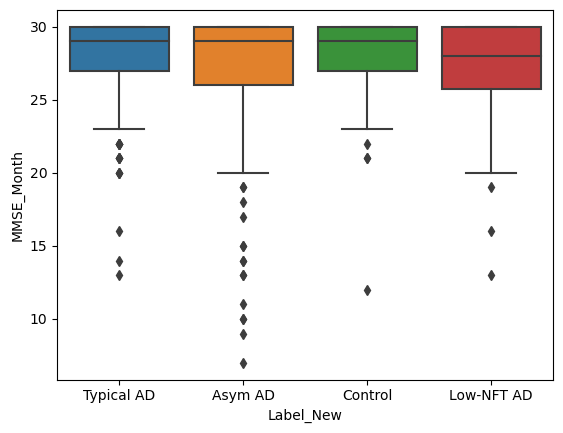

In [165]:
sns.boxplot(data=Add_Info, x='Label_New', y='MMSE_Month')

<Axes: xlabel='Label', ylabel='MMSE_Month'>

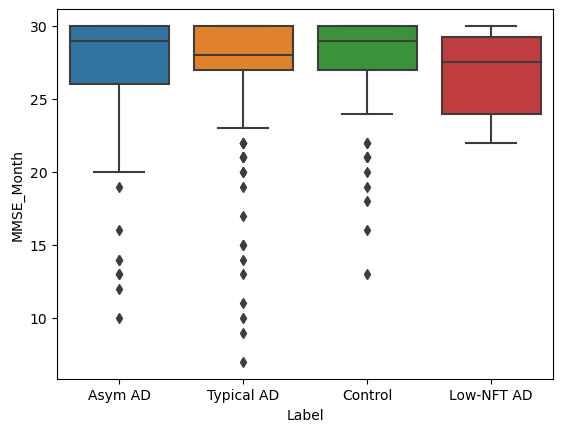

In [166]:
sns.boxplot(data=Add_Info, x='Label', y='MMSE_Month')

# 4 Output

In [123]:
# output Mapping
ReverseMapping = {0:'Control', 1:'Typical AD', 2: 'Asym AD', 3: 'Low-NFT AD'}
ADNI_SID = ANMergeFrame.columns.values
print(len(ADNI_SID))
fname ="./ADNI_Transfered_Label_log.csv"
fh = open(fname, 'w')
fh.write("Sample_ID,Label\n")
for i in range(len(ADNI_SID)):
    fh.write("%s,%s\n" % (ADNI_SID[i], ReverseMapping[y_pred[i]]))
fh.close()


744


In [32]:
ANMergeFrame

,116_S_1249,037_S_4410,006_S_4153,116_S_1232,099_S_4205,007_S_4467,128_S_0205,003_S_2374,036_S_4491,098_S_4059,...,082_S_4339,022_S_2379,014_S_4668,130_S_0289,141_S_4456,009_S_2381,053_S_4557,073_S_4300,041_S_4014,007_S_0101
A1BG,3.651000,3.183000,3.278000,3.371000,3.358000,3.504000,3.194000,3.002000,3.855000,3.59400,...,3.655000,3.345000,3.330000,3.368000,3.665000,3.302000,3.403000,3.53000,3.532000,3.298000
A2M,3.039000,3.543000,3.528000,3.835000,3.392000,3.081000,3.146000,3.281000,3.974000,3.51100,...,3.725000,3.441000,3.497000,3.128000,3.285000,3.524000,3.515000,3.65100,3.609000,3.804000
A4GALT,2.056500,2.349000,2.526000,2.472000,2.296500,2.353500,2.548000,2.396500,3.026500,2.57200,...,2.582500,2.585500,2.598000,2.374000,2.627000,2.838000,2.771500,2.32800,2.823000,2.774500
AAAS,7.043000,6.773000,6.910000,7.209000,6.920000,7.053000,7.079000,6.618000,7.382000,6.82000,...,7.024000,7.028000,6.950000,6.878000,7.233000,6.805000,7.265000,7.37500,7.257000,6.970000
AAK1,4.282167,4.661833,4.661500,4.608833,4.770167,4.618000,5.224333,4.104500,4.282333,4.42950,...,4.667833,4.728333,4.845333,4.156500,4.826333,4.581667,4.654167,4.50750,4.462667,4.452500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,4.739500,4.702333,4.545333,4.562500,4.890667,4.597833,4.599333,4.643333,4.559833,4.57150,...,4.665833,4.395333,4.435333,4.723667,4.468000,4.472167,4.609833,4.73350,4.091000,4.362333
ZYG11B,5.317500,5.388000,5.628000,5.463000,5.647500,5.573250,5.561250,5.611250,5.293750,5.40025,...,5.320250,5.524250,5.411250,5.362500,5.259750,5.442750,5.140000,5.38775,5.057250,4.992000
ZYX,9.219000,8.378500,9.108500,9.321000,9.030000,8.963500,8.534500,9.034000,10.088000,9.35650,...,9.879500,9.403000,9.310500,9.196500,9.506000,9.290000,9.809000,9.52150,9.581000,9.922500
ZZEF1,7.301000,6.758000,7.336500,7.168500,7.202500,7.047500,6.917500,6.950000,7.680000,6.82400,...,7.536000,7.097500,6.766000,7.177000,6.975000,6.703500,7.281000,6.98250,6.686500,7.264500


In [33]:
ADNI_SID

array(['116_S_1249', '037_S_4410', '006_S_4153', '116_S_1232',
       '099_S_4205', '007_S_4467', '128_S_0205', '003_S_2374',
       '036_S_4491', '098_S_4059', '031_S_2018', '002_S_4654',
       '019_S_4285', '141_S_4426', '067_S_4072', '037_S_4308',
       '041_S_4200', '128_S_0200', '129_S_4220', '018_S_4313',
       '067_S_0257', '029_S_1218', '141_S_4053', '136_S_4408',
       '021_S_2142', '114_S_4404', '116_S_4167', '116_S_4209',
       '073_S_4360', '072_S_4539', '007_S_2394', '128_S_1407',
       '109_S_2200', '057_S_1269', '022_S_1097', '010_S_0420',
       '072_S_2083', '014_S_4615', '073_S_4259', '002_S_1268',
       '024_S_0985', '073_S_4382', '127_S_0684', '067_S_4310',
       '035_S_0156', '041_S_4427', '127_S_0622', '129_S_4396',
       '019_S_4477', '002_S_1261', '041_S_4271', '003_S_1122',
       '941_S_2060', '012_S_4094', '129_S_4287', '135_S_4356',
       '136_S_0186', '098_S_4050', '073_S_4155', '073_S_2182',
       '013_S_4580', '100_S_1286', '072_S_2027', '099_S